<a href="https://colab.research.google.com/github/RickyF404/Tesi/blob/main/Dataset_inclinometri_(corretto).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

import numpy as np
import matplotlib.pyplot as plt
import gdown

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer

In [2]:
url_inc = "https://drive.google.com/uc?id=1jZZ7Oje34Rj_H0_R7SkHntEhu2KZv_It"
output_inc = "data_inc.csv"
gdown.download(url_inc, output_inc)

Downloading...
From: https://drive.google.com/uc?id=1jZZ7Oje34Rj_H0_R7SkHntEhu2KZv_It
To: /content/data_inc.csv
100%|██████████| 2.59M/2.59M [00:00<00:00, 41.7MB/s]


'data_inc.csv'

In [3]:
df_inc = pd.read_csv("/content/data_inc.csv", encoding = "utf-8")

mapping = {
    "I_P01_01_C_X": "Mode 1",
    "I_P01_01_C_Y": "Mode 2",
    "I_P02_01_C_X": "Mode 3",
    "I_P02_01_C_Y": "Mode 4",
    "I_P03_01_C_X": "Mode 5",
    "I_P03_01_C_Y": "Mode 6",
}

df_inc = df_inc.rename(columns=mapping)

df_inc["timestamp"] = pd.to_datetime(df_inc["timestamp"])
df_inc["timestamp"] = df_inc["timestamp"].dt.tz_localize(None)
df_inc = df_inc.sort_values("timestamp")

df_inc = df_inc[df_inc["timestamp"] >= "2024-01-01"]

percentuale_nan = (df_inc.isna().sum() / len(df_inc)) * 100

print("Percentuale di NaN per colonna:")
print(percentuale_nan)

df_inc = df_inc.set_index('timestamp')

# interpolazione temporale
df_inc = df_inc.interpolate(method='time')

df_inc = df_inc.reset_index()

end = "2024-09-01"
df = df_inc[(df_inc["timestamp"] < end)]

Percentuale di NaN per colonna:
Unnamed: 0    0.000000
timestamp     0.000000
Mode 1        1.092896
Mode 2        1.092896
Mode 3        0.056529
Mode 4        0.056529
Mode 5        0.043967
Mode 6        0.043967
dtype: float64


In [4]:
mean_inc = df_inc.groupby(df_inc["timestamp"].dt.to_period("M")).mean()

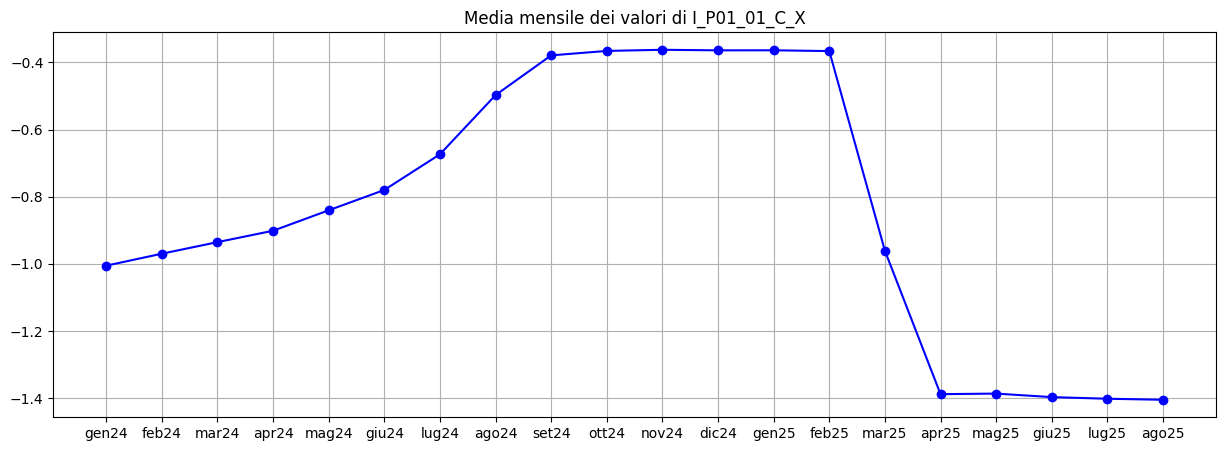

In [5]:
labels=["gen24", "feb24", "mar24", "apr24", "mag24", "giu24", "lug24", "ago24", "set24", "ott24", "nov24", "dic24", "gen25", "feb25", "mar25", "apr25", "mag25", "giu25", "lug25", "ago25"]
x = np.arange(len(labels))
figure, ax = plt.subplots(figsize=(15, 5))
ax.plot(labels, mean_inc["Mode 1"].values, "o-", color="blue")
ax.set_title("Media mensile dei valori di I_P01_01_C_X")
plt.grid(True)
plt.show()

In [6]:
def create_fake_month(df, frac_per_month, random_state):
  rng = np.random.default_rng(seed=random_state) # generatore casuale con seed
  df["day"] = df["timestamp"].dt.floor("D")
  df["year_month"] = df["timestamp"].dt.to_period("M")
  train_indices = []

  for ym, group in df.groupby("year_month"):
    days = group["day"].unique()
    n_take = max(1, int(len(days) * frac_per_month))
    sampled_days = rng.choice(days, size=n_take, replace=False)
    sel = group[group["day"].isin(sampled_days)].index.tolist()
    train_indices += sel

  train_df = df.loc[train_indices].copy()
  valid_df = df.drop(index=train_indices).copy()
  train_df = train_df.drop(columns=["day", "year_month"])
  valid_df = valid_df.drop(columns=["day", "year_month"])
  train_df = train_df.sort_values("timestamp")
  valid_df = valid_df.sort_values("timestamp")

  return train_df, valid_df

# PCA

In [66]:
def anomaly_rate_PCA(train_df, valid_df, features):
  scaler = StandardScaler()
  X_train = scaler.fit_transform(train_df[features])
  X_val = scaler.transform(valid_df[features])

  pca = PCA(n_components = 0.95)
  X_train_pca = pca.fit_transform(X_train)
  X_train_reconstructed = pca.inverse_transform(X_train_pca)
  train_err = np.mean((X_train - X_train_reconstructed)**2, axis = 1)
  threshold = np.percentile(train_err, 98.5)

  X_val_pca = pca.transform(X_val)
  X_val_reconstructed = pca.inverse_transform(X_val_pca)
  val_err = np.mean((X_val - X_val_reconstructed)**2, axis = 1)
  anomaly_rate = np.mean(val_err > threshold)

  return anomaly_rate

In [70]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results = []
window_size = 2
n_months = 8
start_date = df["timestamp"].min()
valid_df = df_inc[(df_inc["timestamp"] >= "2024-09-01") & (df_inc["timestamp"] < "2025-09-01")]

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_df = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  anomaly = anomaly_rate_PCA(train_df, valid_df, features)

  train_months = sorted(train_df["timestamp"].dt.to_period("M").unique())

  results.append({"train_months": [str(x) for x in train_months] , "window_size": len(train_months), "anomaly rate": anomaly})

results_df_2m_PCA = pd.DataFrame(results)
print(results_df_2m_PCA)

         train_months  window_size  anomaly rate
0  [2024-01, 2024-02]            2      0.999579
1  [2024-02, 2024-03]            2      1.000000
2  [2024-03, 2024-04]            2      1.000000
3  [2024-04, 2024-05]            2      0.933298
4  [2024-05, 2024-06]            2      1.000000
5  [2024-06, 2024-07]            2      1.000000
6  [2024-07, 2024-08]            2      0.832771


In [71]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results = []
window_size = 4
n_months = 8
start_date = df["timestamp"].min()
valid_df = df_inc[(df_inc["timestamp"] >= "2024-09-01") & (df_inc["timestamp"] < "2025-09-01")]


for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_df = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  anomaly = anomaly_rate_PCA(train_df, valid_df, features)

  train_months = sorted(train_df["timestamp"].dt.to_period("M").unique())

  results.append({"train_months": [str(x) for x in train_months] , "window_size": len(train_months), "anomaly rate": anomaly})

results_df_4m_PCA = pd.DataFrame(results)
print(results_df_4m_PCA)

                           train_months  window_size  anomaly rate
0  [2024-01, 2024-02, 2024-03, 2024-04]            4      1.000000
1  [2024-02, 2024-03, 2024-04, 2024-05]            4      1.000000
2  [2024-03, 2024-04, 2024-05, 2024-06]            4      1.000000
3  [2024-04, 2024-05, 2024-06, 2024-07]            4      1.000000
4  [2024-05, 2024-06, 2024-07, 2024-08]            4      0.903267


In [72]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results = []
window_size = 6
n_months = 8
start_date = df["timestamp"].min()
valid_df = df_inc[(df_inc["timestamp"] >= "2024-09-01") & (df_inc["timestamp"] < "2025-09-01")]

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_df = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  anomaly = anomaly_rate_PCA(train_df, valid_df, features)

  train_months = sorted(train_df["timestamp"].dt.to_period("M").unique())

  results.append({"train_months": [str(x) for x in train_months] ,  "window_size": len(train_months), "anomaly rate": anomaly})

results_df_6m_PCA = pd.DataFrame(results)
print(results_df_6m_PCA)

                                        train_months  window_size  \
0  [2024-01, 2024-02, 2024-03, 2024-04, 2024-05, ...            6   
1  [2024-02, 2024-03, 2024-04, 2024-05, 2024-06, ...            6   
2  [2024-03, 2024-04, 2024-05, 2024-06, 2024-07, ...            6   

   anomaly rate  
0      1.000000  
1      1.000000  
2      0.996101  


In [76]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results_2m_fake = []
train_df, valid_df = create_fake_month(df_inc, frac_per_month=0.1, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

anomaly = anomaly_rate_PCA(train_df, valid_df, features)
results_2m_fake.append({"window_size": 2, "anomaly": anomaly})

results_df_2m_fake_PCA = pd.DataFrame(results_2m_fake)
print(results_df_2m_fake_PCA)

Giorni training: 57
Giorni validation: 547
   window_size   anomaly
0            2  0.014508


In [77]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results_4m_fake = []

train_df, valid_df = create_fake_month(df_inc, frac_per_month=0.2, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

anomaly = anomaly_rate_PCA(train_df, valid_df, features)
results_4m_fake.append({"window_size": 4, "anomaly": anomaly})

results_df_4m_fake_PCA = pd.DataFrame(results_4m_fake)
print(results_df_4m_fake_PCA)

Giorni training: 117
Giorni validation: 487
   window_size   anomaly
0            4  0.018494


In [78]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results_6m_fake = []

train_df, valid_df = create_fake_month(df_inc, frac_per_month=0.3, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

anomaly = anomaly_rate_PCA(train_df, valid_df, features)
results_6m_fake.append({"window_size": 6, "anomaly": anomaly})

results_df_6m_fake_PCA = pd.DataFrame(results_6m_fake)
print(results_df_6m_fake_PCA)

Giorni training: 177
Giorni validation: 427
   window_size   anomaly
0            6  0.013206


In [80]:
# salvataggio dei risultati PCA
# real_results_df_PCA = pd.concat([results_df_2m_PCA, results_df_4m_PCA, results_df_6m_PCA])
# real_results_df_PCA.to_csv("/content/drive/MyDrive/real_inclinometri_PCA_v2.csv", index=False)

# fake_results_df_PCA = pd.concat([results_df_2m_fake_PCA, results_df_4m_fake_PCA, results_df_6m_fake_PCA])
# fake_results_df_PCA.to_csv("/content/drive/MyDrive/fake_inclinometri_PCA_v2.csv", index=False)

# SVM

In [7]:
def anomaly_rate_SVM(train_df, valid_df, features):
  scaler = StandardScaler()
  # scaler = RobustScaler()
  X_train = scaler.fit_transform(train_df[features])
  X_val = scaler.transform(valid_df[features])

  ocsvm = OneClassSVM(kernel="rbf", nu=0.01, gamma=0.01)
  ocsvm.fit(X_train)

  preds = ocsvm.predict(X_val)
  anomaly_rate = np.mean(preds == -1)

  return anomaly_rate

In [8]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results = []
window_size = 2
n_months = 8
start_date = df["timestamp"].min()
valid_df = df_inc[(df_inc["timestamp"] >= "2024-09-01") & (df_inc["timestamp"] < "2025-09-01")]

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_df = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  anomaly = anomaly_rate_SVM(train_df, valid_df, features)

  train_months = sorted(train_df["timestamp"].dt.to_period("M").unique())

  results.append({"train_months": [str(x) for x in train_months] , "window_size": len(train_months), "anomaly rate": anomaly})

results_df_2m_SVM = pd.DataFrame(results)
print(results_df_2m_SVM)

         train_months  window_size  anomaly rate
0  [2024-01, 2024-02]            2      1.000000
1  [2024-02, 2024-03]            2      1.000000
2  [2024-03, 2024-04]            2      1.000000
3  [2024-04, 2024-05]            2      1.000000
4  [2024-05, 2024-06]            2      1.000000
5  [2024-06, 2024-07]            2      0.998419
6  [2024-07, 2024-08]            2      0.966913


In [9]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results = []
window_size = 4
n_months = 8
start_date = df["timestamp"].min()
valid_df = df_inc[(df_inc["timestamp"] >= "2024-09-01") & (df_inc["timestamp"] < "2025-09-01")]

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_df = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  anomaly = anomaly_rate_SVM(train_df, valid_df, features)

  train_months = sorted(train_df["timestamp"].dt.to_period("M").unique())

  results.append({"train_months": [str(x) for x in train_months] , "window_size": len(train_months), "anomaly rate": anomaly})

results_df_4m_SVM = pd.DataFrame(results)
print(results_df_4m_SVM)

                           train_months  window_size  anomaly rate
0  [2024-01, 2024-02, 2024-03, 2024-04]            4      1.000000
1  [2024-02, 2024-03, 2024-04, 2024-05]            4      1.000000
2  [2024-03, 2024-04, 2024-05, 2024-06]            4      1.000000
3  [2024-04, 2024-05, 2024-06, 2024-07]            4      1.000000
4  [2024-05, 2024-06, 2024-07, 2024-08]            4      0.889568


In [10]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results = []
window_size = 6
n_months = 8
start_date = df["timestamp"].min()
valid_df = df_inc[(df_inc["timestamp"] >= "2024-09-01") & (df_inc["timestamp"] < "2025-09-01")]

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_df = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  anomaly = anomaly_rate_SVM(train_df, valid_df, features)

  train_months = sorted(train_df["timestamp"].dt.to_period("M").unique())

  results.append({"train_months": [str(x) for x in train_months] ,  "window_size": len(train_months), "anomaly rate": anomaly})

results_df_6m_SVM = pd.DataFrame(results)
print(results_df_6m_SVM)

                                        train_months  window_size  \
0  [2024-01, 2024-02, 2024-03, 2024-04, 2024-05, ...            6   
1  [2024-02, 2024-03, 2024-04, 2024-05, 2024-06, ...            6   
2  [2024-03, 2024-04, 2024-05, 2024-06, 2024-07, ...            6   

   anomaly rate  
0      1.000000  
1      1.000000  
2      0.849104  


In [11]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results_2m_fake = []
train_df, valid_df = create_fake_month(df_inc, frac_per_month=0.1, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

anomaly = anomaly_rate_SVM(train_df, valid_df, features)
results_2m_fake.append({"window_size": 2, "anomaly": anomaly})

results_df_2m_fake_SVM = pd.DataFrame(results_2m_fake)
print(results_df_2m_fake_SVM)

Giorni training: 57
Giorni validation: 547
   window_size   anomaly
0            2  0.014438


In [12]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results_4m_fake = []

train_df, valid_df = create_fake_month(df_inc, frac_per_month=0.2, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

anomaly = anomaly_rate_SVM(train_df, valid_df, features)
results_4m_fake.append({"window_size": 4, "anomaly": anomaly})

results_df_4m_fake_SVM = pd.DataFrame(results_4m_fake)
print(results_df_4m_fake_SVM)

Giorni training: 117
Giorni validation: 487
   window_size   anomaly
0            4  0.010568


In [13]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results_6m_fake = []

train_df, valid_df = create_fake_month(df_inc, frac_per_month=0.3, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

anomaly = anomaly_rate_SVM(train_df, valid_df, features)
results_6m_fake.append({"window_size": 6, "anomaly": anomaly})

results_df_6m_fake_SVM = pd.DataFrame(results_6m_fake)
print(results_df_6m_fake_SVM)

Giorni training: 177
Giorni validation: 427
   window_size   anomaly
0            6  0.012763


In [14]:
# salvataggio dei risultati SVM
# real_results_df_SVM = pd.concat([results_df_2m_SVM, results_df_4m_SVM, results_df_6m_SVM])
# real_results_df_SVM.to_csv("/content/drive/MyDrive/real_inclinometri_SVM_v2.csv", index=False)

# fake_results_df_SVM = pd.concat([results_df_2m_fake_SVM, results_df_4m_fake_SVM, results_df_6m_fake_SVM])
# fake_results_df_SVM.to_csv("/content/drive/MyDrive/fake_inclinometri_SVM_v2.csv", index=False)

# LOF

In [15]:
def anomaly_rate_LOF(train_df, valid_df, features, n_neighbors=20, contamination=0.01):
  scaler = StandardScaler()
  X_train = scaler.fit_transform(train_df[features])
  X_valid = scaler.transform(valid_df[features])

  lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, novelty=True)
  lof.fit(X_train)

  y_pred = lof.predict(X_valid)
  anomaly_rate = np.mean(y_pred == -1)
  return anomaly_rate

In [16]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results = []
window_size = 2
n_months = 8
start_date = df["timestamp"].min()
valid_df = df_inc[(df_inc["timestamp"] >= "2024-09-01") & (df_inc["timestamp"] < "2025-09-01")]

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_df = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  anomaly = anomaly_rate_LOF(train_df, valid_df, features)

  train_months = sorted(train_df["timestamp"].dt.to_period("M").unique())

  results.append({"train_months": [str(x) for x in train_months] , "window_size": len(train_months), "anomaly rate": anomaly})

results_df_2m_LOF = pd.DataFrame(results)
print(results_df_2m_LOF)

         train_months  window_size  anomaly rate
0  [2024-01, 2024-02]            2      1.000000
1  [2024-02, 2024-03]            2      1.000000
2  [2024-03, 2024-04]            2      1.000000
3  [2024-04, 2024-05]            2      1.000000
4  [2024-05, 2024-06]            2      1.000000
5  [2024-06, 2024-07]            2      1.000000
6  [2024-07, 2024-08]            2      0.975448


In [17]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results = []
window_size = 4
n_months = 8
start_date = df["timestamp"].min()
valid_df = df_inc[(df_inc["timestamp"] >= "2024-09-01") & (df_inc["timestamp"] < "2025-09-01")]

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_df = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  anomaly = anomaly_rate_LOF(train_df, valid_df, features)

  train_months = sorted(train_df["timestamp"].dt.to_period("M").unique())

  results.append({"train_months": [str(x) for x in train_months] , "window_size": len(train_months), "anomaly rate": anomaly})

results_df_4m_LOF = pd.DataFrame(results)
print(results_df_4m_LOF)

                           train_months  window_size  anomaly rate
0  [2024-01, 2024-02, 2024-03, 2024-04]            4       1.00000
1  [2024-02, 2024-03, 2024-04, 2024-05]            4       1.00000
2  [2024-03, 2024-04, 2024-05, 2024-06]            4       1.00000
3  [2024-04, 2024-05, 2024-06, 2024-07]            4       1.00000
4  [2024-05, 2024-06, 2024-07, 2024-08]            4       0.97471


In [18]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results = []
window_size = 6
n_months = 8
start_date = df["timestamp"].min()
valid_df = df_inc[(df_inc["timestamp"] >= "2024-09-01") & (df_inc["timestamp"] < "2025-09-01")]

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_df = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  anomaly = anomaly_rate_LOF(train_df, valid_df, features)

  train_months = sorted(train_df["timestamp"].dt.to_period("M").unique())

  results.append({"train_months": [str(x) for x in train_months] ,  "window_size": len(train_months), "anomaly rate": anomaly})

results_df_6m_LOF = pd.DataFrame(results)
print(results_df_6m_LOF)

                                        train_months  window_size  \
0  [2024-01, 2024-02, 2024-03, 2024-04, 2024-05, ...            6   
1  [2024-02, 2024-03, 2024-04, 2024-05, 2024-06, ...            6   
2  [2024-03, 2024-04, 2024-05, 2024-06, 2024-07, ...            6   

   anomaly rate  
0      1.000000  
1      1.000000  
2      0.979557  


In [19]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results_2m_fake = []
train_df, valid_df = create_fake_month(df_inc, frac_per_month=0.1, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

anomaly = anomaly_rate_LOF(train_df, valid_df, features)
results_2m_fake.append({"window_size": 2, "anomaly": anomaly})

results_df_2m_fake_LOF = pd.DataFrame(results_2m_fake)
print(results_df_2m_fake_LOF)

Giorni training: 57
Giorni validation: 547
   window_size   anomaly
0            2  0.048174


In [20]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results_4m_fake = []

train_df, valid_df = create_fake_month(df_inc, frac_per_month=0.2, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

anomaly = anomaly_rate_LOF(train_df, valid_df, features)
results_4m_fake.append({"window_size": 4, "anomaly": anomaly})

results_df_4m_fake_LOF = pd.DataFrame(results_4m_fake)
print(results_df_4m_fake_LOF)

Giorni training: 117
Giorni validation: 487
   window_size   anomaly
0            4  0.052762


In [21]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results_6m_fake = []

train_df, valid_df = create_fake_month(df_inc, frac_per_month=0.3, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

anomaly = anomaly_rate_LOF(train_df, valid_df, features)
results_6m_fake.append({"window_size": 6, "anomaly": anomaly})

results_df_6m_fake_LOF = pd.DataFrame(results_6m_fake)
print(results_df_6m_fake_LOF)

Giorni training: 177
Giorni validation: 427
   window_size   anomaly
0            6  0.026057


In [22]:
# salvataggio dei risultati LOF
real_results_df_LOF = pd.concat([results_df_2m_LOF, results_df_4m_LOF, results_df_6m_LOF])
real_results_df_LOF.to_csv("/content/drive/MyDrive/real_inclinometri_LOF_v2.csv", index=False)

fake_results_df_LOF = pd.concat([results_df_2m_fake_LOF, results_df_4m_fake_LOF, results_df_6m_fake_LOF])
fake_results_df_LOF.to_csv("/content/drive/MyDrive/fake_inclinometri_LOF_v2.csv", index=False)

# VAE senza temperatura

In [23]:
class Sampling(Layer):
  def call(self, inputs):
    z_mean, z_log_var = inputs
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class VAE(keras.Model):
  def __init__(self, input_dim, latent_dim = 2, beta = 0.01, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.beta = beta

    #encoder
    x_input = keras.Input(shape=(input_dim,))
    x = layers.Dense(48, activation="relu")(x_input)
    x = layers.Dense(24, activation="relu")(x)
    x = layers.Dense(12, activation="relu")(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    z = Sampling()([z_mean, z_log_var])
    self.encoder = keras.Model(x_input, [z_mean, z_log_var, z])

    #decoder
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(12, activation="relu")(latent_inputs)
    x = layers.Dense(24, activation="relu")(x)
    x = layers.Dense(48, activation="relu")(x)
    outputs = layers.Dense(input_dim, activation="linear")(x)

    self.decoder = keras.Model(latent_inputs, outputs)

  def train_step(self, data):
    x, y = data

    with tf.GradientTape() as tape:
      z_mean, z_log_var, z = self.encoder(x, training = True)
      reconstruction = self.decoder(z, training = True)

      reconstruction_loss = tf.reduce_mean(tf.square(x - reconstruction))
      kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
      total_loss = reconstruction_loss + self.beta * kl_loss

    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    return {"loss": total_loss, "recon_loss": reconstruction_loss, "kl_loss": kl_loss}

  def call(self, inputs):
    z_mean, _,  z = self.encoder(inputs)
    return self.decoder(z)

In [25]:
# parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results = []
window_size = 1
n_months = 8
start_date = df["timestamp"].min()
val_data = df_inc[(df_inc["timestamp"] >= "2024-09-01") & (df_inc["timestamp"] < "2025-09-01")]

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  scaler_X = StandardScaler()
  scaler_T = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])

  X_val = scaler_X.transform(val_data[features])

  vae = VAE(input_dim=X_train.shape[1], latent_dim=2)
  vae.build(input_shape=(None, X_train.shape[1]))

  vae.compile(optimizer=keras.optimizers.Adam())

  vae.fit(
      X_train,
      X_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  vae.save_weights(f"/content/drive/MyDrive/VAE_no_temp_1month_inclinometro_v2_{m}.weights.h5")

  X_pred = vae.predict(X_val)
  mse = np.mean(np.square(X_val - X_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_1m_VAE = pd.DataFrame(results)
print(results_df_1m_VAE)

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
  train_months  window_size  anomaly rate
0    [2024-01]            1      0.000000
1    [2024-02]            1      0.018546
2    [2024-03]            1      0.005163
3    [2024-04]            1      0.000000
4    [2024-05]            1      0.000000
5    [2024-06]            1      0.001264
6    [2024-07]            1      0.000000
7    [2024-08]            1      0.000000


In [26]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results = []
window_size = 2
n_months = 8
start_date = df["timestamp"].min()
val_data = df_inc[(df_inc["timestamp"] >= "2024-09-01") & (df_inc["timestamp"] < "2025-09-01")]

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  scaler_X = StandardScaler()
  scaler_T = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])

  X_val = scaler_X.transform(val_data[features])

  vae = VAE(input_dim=X_train.shape[1], latent_dim=2)
  vae.build(input_shape=(None, X_train.shape[1]))

  vae.compile(optimizer=keras.optimizers.Adam())

  vae.fit(
      X_train,
      X_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  vae.save_weights(f"/content/drive/MyDrive/VAE_no_temp_2month_inclinometro_v2_{m}.weights.h5")

  X_pred = vae.predict(X_val)
  mse = np.mean(np.square(X_val - X_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_2m_VAE = pd.DataFrame(results)
print(results_df_2m_VAE)

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
         train_months  window_size  anomaly rate
0  [2024-01, 2024-02]            2      0.000000
1  [2024-02, 2024-03]            2      0.011802
2  [2024-03, 2024-04]            2      0.000632
3  [2024-04, 2024-05]            2      0.000000
4  [2024-05, 2024-06]            2      0.000527
5  [2024-06, 2024-07]            2      0.000000
6  [2024-07, 2024-08]            2      0.000000


In [27]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results = []
window_size = 4
n_months = 8
start_date = df["timestamp"].min()
val_data = df_inc[(df_inc["timestamp"] >= "2024-09-01") & (df_inc["timestamp"] < "2025-09-01")]

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  scaler_X = StandardScaler()
  scaler_T = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])

  X_val = scaler_X.transform(val_data[features])

  vae = VAE(input_dim=X_train.shape[1], latent_dim=2)
  vae.build(input_shape=(None, X_train.shape[1]))

  vae.compile(optimizer=keras.optimizers.Adam())

  vae.fit(
      X_train,
      X_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  vae.save_weights(f"/content/drive/MyDrive/VAE_no_temp_4month_inclinometro_v2_{m}.weights.h5")

  X_pred = vae.predict(X_val)
  mse = np.mean(np.square(X_val - X_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_4m_VAE = pd.DataFrame(results)
print(results_df_4m_VAE)

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
                           train_months  window_size  anomaly rate
0  [2024-01, 2024-02, 2024-03, 2024-04]            4      0.007482
1  [2024-02, 2024-03, 2024-04, 2024-05]            4      0.001054
2  [2024-03, 2024-04, 2024-05, 2024-06]            4      0.001054
3  [2024-04, 2024-05, 2024-06, 2024-07]            4      0.000105
4  [2024-05, 2024-06, 2024-07, 2024-08]            4      0.000000


In [28]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results = []
window_size = 6
n_months = 8
start_date = df["timestamp"].min()
val_data = df_inc[(df_inc["timestamp"] >= "2024-09-01") & (df_inc["timestamp"] < "2025-09-01")]

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  scaler_X = StandardScaler()
  scaler_T = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])

  X_val = scaler_X.transform(val_data[features])

  vae = VAE(input_dim=X_train.shape[1], latent_dim=2)
  vae.build(input_shape=(None, X_train.shape[1]))

  vae.compile(optimizer=keras.optimizers.Adam())

  vae.fit(
      X_train,
      X_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  vae.save_weights(f"/content/drive/MyDrive/VAE_no_temp_6month_inclinometro_v2_{m}.weights.h5")

  X_pred = vae.predict(X_val)
  mse = np.mean(np.square(X_val - X_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_6m_VAE = pd.DataFrame(results)
print(results_df_6m_VAE)

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
                                        train_months  window_size  \
0  [2024-01, 2024-02, 2024-03, 2024-04, 2024-05, ...            6   
1  [2024-02, 2024-03, 2024-04, 2024-05, 2024-06, ...            6   
2  [2024-03, 2024-04, 2024-05, 2024-06, 2024-07, ...            6   

   anomaly rate  
0      0.020021  
1      0.000000  
2      0.004636  


In [29]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results_1m_fake = []
train_df, valid_df = create_fake_month(df_inc, frac_per_month=0.05, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])

X_val = scaler_X.transform(valid_df[features])

vae = VAE(input_dim=X_train.shape[1], latent_dim=2)

vae.compile(optimizer=keras.optimizers.Adam())

vae.fit(
    X_train,
    X_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

X_pred = vae.predict(X_val)
mse = np.mean(np.square(X_val - X_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_1m_fake.append({"window_size": 1, "anomaly": anomaly_rate})

results_df_1m_fake_VAE = pd.DataFrame(results_1m_fake)
print(results_df_1m_fake_VAE)

Giorni training: 20
Giorni validation: 584
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
   window_size  anomaly
0            1  0.02443


In [30]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results_2m_fake = []
train_df, valid_df = create_fake_month(df_inc, frac_per_month=0.1, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])

X_val = scaler_X.transform(valid_df[features])

vae = VAE(input_dim=X_train.shape[1], latent_dim=2)

vae.compile(optimizer=keras.optimizers.Adam())

vae.fit(
    X_train,
    X_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

X_pred = vae.predict(X_val)
mse = np.mean(np.square(X_val - X_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_2m_fake.append({"window_size": 2, "anomaly": anomaly_rate})

results_df_2m_fake_VAE = pd.DataFrame(results_2m_fake)
print(results_df_2m_fake_VAE)

Giorni training: 57
Giorni validation: 547
451/451 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
   window_size  anomaly
0            2  0.01659


In [31]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results_4m_fake = []
train_df, valid_df = create_fake_month(df_inc, frac_per_month=0.2, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])

X_val = scaler_X.transform(valid_df[features])

vae = VAE(input_dim=X_train.shape[1], latent_dim=2)

vae.compile(optimizer=keras.optimizers.Adam())

vae.fit(
    X_train,
    X_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

X_pred = vae.predict(X_val)
mse = np.mean(np.square(X_val - X_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_4m_fake.append({"window_size": 4, "anomaly": anomaly_rate})

results_df_4m_fake_VAE = pd.DataFrame(results_4m_fake)
print(results_df_4m_fake_VAE)

Giorni training: 117
Giorni validation: 487
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
   window_size   anomaly
0            4  0.012977


In [32]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results_6m_fake = []
train_df, valid_df = create_fake_month(df_inc, frac_per_month=0.3, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])

X_val = scaler_X.transform(valid_df[features])

vae = VAE(input_dim=X_train.shape[1], latent_dim=2)

vae.compile(optimizer=keras.optimizers.Adam())

vae.fit(
    X_train,
    X_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

X_pred = vae.predict(X_val)
mse = np.mean(np.square(X_val - X_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_6m_fake.append({"window_size": 6, "anomaly": anomaly_rate})

results_df_6m_fake_VAE = pd.DataFrame(results_6m_fake)
print(results_df_6m_fake_VAE)

Giorni training: 177
Giorni validation: 427
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
   window_size   anomaly
0            6  0.014535


In [33]:
# salvataggio dei risultati VAE (no temperatura)
real_results_df_VAE = pd.concat([results_df_1m_VAE, results_df_2m_VAE, results_df_4m_VAE, results_df_6m_VAE])
real_results_df_VAE.to_csv("/content/drive/MyDrive/real_inclinometri_VAE_v2.csv", index=False)

fake_results_df_VAE = pd.concat([results_df_1m_fake_VAE, results_df_2m_fake_VAE, results_df_4m_fake_VAE, results_df_6m_fake_VAE])
fake_results_df_VAE.to_csv("/content/drive/MyDrive/fake_inclinometri_VAE_v2.csv", index=False)

# AE senza temperatura

In [34]:
def build_ae(input_dim, latent_dim=2):
  #encoder
  input_enc = layers.Input(shape=(input_dim,))
  x = layers.Dense(64, activation="relu")(input_enc)
  x = layers.Dense(32, activation="relu")(x)
  x = layers.Dense(16, activation="relu")(x)
  z = layers.Dense(latent_dim, activation="relu", name="latent")(x)

  #decoder
  x = layers.Dense(16, activation="relu")(z)
  x = layers.Dense(32, activation="relu")(x)
  x = layers.Dense(64, activation="relu")(x)
  output_dec = layers.Dense(input_dim, activation="linear")(x)

  #autoencoder
  ae = keras.Model(input_enc, output_dec, name="autoencoder")
  ae.compile(optimizer="adam", loss="mse")
  return ae

In [35]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results = []
window_size = 1
n_months = 8
start_date = df["timestamp"].min()
val_data = df_inc[(df_inc["timestamp"] >= "2024-09-01") & (df_inc["timestamp"] < "2025-09-01")]

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  scaler_X = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])
  X_val = scaler_X.transform(val_data[features])

  ae = build_ae(input_dim=X_train.shape[1], latent_dim=2)

  ae.fit(
      X_train,
      X_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  ae.save_weights(f"/content/drive/MyDrive/AE_no_temp_1month_inclinometro_v2_{m}.weights.h5")

  X_pred = ae.predict(X_val)
  mse = np.mean(np.square(X_val - X_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_1m_AE = pd.DataFrame(results)
print(results_df_1m_AE)

297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
  train_months  window_size  anomaly rate
0    [2024-01]            1      0.000000
1    [2024-02]            1      0.005374
2    [2024-03]            1      0.000948
3    [2024-04]            1      0.000000
4    [2024-05]            1      0.000105
5    [2024-06]            1      0.000000
6    [2024-07]            1      0.000000
7    [2024-08]            1      0.000000


In [36]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results = []
window_size = 2
n_months = 8
start_date = df["timestamp"].min()
val_data = df_inc[(df_inc["timestamp"] >= "2024-09-01") & (df_inc["timestamp"] < "2025-09-01")]

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  scaler_X = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])
  X_val = scaler_X.transform(val_data[features])

  ae = build_ae(input_dim=X_train.shape[1], latent_dim=2)

  ae.fit(
      X_train,
      X_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )


  ae.save_weights(f"/content/drive/MyDrive/AE_no_temp_2month_inclinometro_v2_{m}.weights.h5")

  X_pred = ae.predict(X_val)
  mse = np.mean(np.square(X_val - X_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_2m_AE = pd.DataFrame(results)
print(results_df_2m_AE)

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
         train_months  window_size  anomaly rate
0  [2024-01, 2024-02]            2      0.007271
1  [2024-02, 2024-03]            2      0.013383
2  [2024-03, 2024-04]            2      0.005585
3  [2024-04, 2024-05]            2      0.009062
4  [2024-05, 2024-06]            2      0.000000
5  [2024-06, 2024-07]            2      0.000000
6  [2024-07, 2024-08]            2      0.000000


In [37]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results = []
window_size = 4
n_months = 8
start_date = df["timestamp"].min()
val_data = df_inc[(df_inc["timestamp"] >= "2024-09-01") & (df_inc["timestamp"] < "2025-09-01")]

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  scaler_X = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])
  X_val = scaler_X.transform(val_data[features])

  ae = build_ae(input_dim=X_train.shape[1], latent_dim=2)

  ae.fit(
      X_train,
      X_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  ae.save_weights(f"/content/drive/MyDrive/AE_no_temp_4month_inclinometro_v2_{m}.weights.h5")

  X_pred = ae.predict(X_val)
  mse = np.mean(np.square(X_val - X_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_4m_AE = pd.DataFrame(results)
print(results_df_4m_AE)

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
                           train_months  window_size  anomaly rate
0  [2024-01, 2024-02, 2024-03, 2024-04]            4      0.002740
1  [2024-02, 2024-03, 2024-04, 2024-05]            4      0.000000
2  [2024-03, 2024-04, 2024-05, 2024-06]            4      0.013172
3  [2024-04, 2024-05, 2024-06, 2024-07]            4      0.000000
4  [2024-05, 2024-06, 2024-07, 2024-08]            4      0.000105


In [38]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results = []
window_size = 6
n_months = 8
start_date = df["timestamp"].min()
val_data = df_inc[(df_inc["timestamp"] >= "2024-09-01") & (df_inc["timestamp"] < "2025-09-01")]

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  scaler_X = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])
  X_val = scaler_X.transform(val_data[features])

  ae = build_ae(input_dim=X_train.shape[1], latent_dim=2)

  ae.fit(
      X_train,
      X_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  ae.save_weights(f"/content/drive/MyDrive/AE_no_temp_6month_inclinometro_v2_{m}.weights.h5")

  X_pred = ae.predict(X_val)
  mse = np.mean(np.square(X_val - X_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_6m_AE = pd.DataFrame(results)
print(results_df_6m_AE)

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
                                        train_months  window_size  \
0  [2024-01, 2024-02, 2024-03, 2024-04, 2024-05, ...            6   
1  [2024-02, 2024-03, 2024-04, 2024-05, 2024-06, ...            6   
2  [2024-03, 2024-04, 2024-05, 2024-06, 2024-07, ...            6   

   anomaly rate  
0      0.008219  
1      0.001475  
2      0.000000  


In [39]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results_1m_fake = []
train_df, valid_df = create_fake_month(df_inc, frac_per_month=0.05, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])

X_val = scaler_X.transform(valid_df[features])

ae = build_ae(input_dim=X_train.shape[1], latent_dim=2)

ae.fit(
    X_train,
    X_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

X_pred = ae.predict(X_val)
mse = np.mean(np.square(X_val - X_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_1m_fake.append({"window_size": 1, "anomaly": anomaly_rate})

results_df_1m_fake_AE = pd.DataFrame(results_1m_fake)
print(results_df_1m_fake_AE)

Giorni training: 20
Giorni validation: 584
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
   window_size   anomaly
0            1  0.028328


In [40]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results_2m_fake = []
train_df, valid_df = create_fake_month(df_inc, frac_per_month=0.1, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])

X_val = scaler_X.transform(valid_df[features])

ae = build_ae(input_dim=X_train.shape[1], latent_dim=2)

ae.fit(
    X_train,
    X_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

X_pred = ae.predict(X_val)
mse = np.mean(np.square(X_val - X_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_2m_fake.append({"window_size": 2, "anomaly": anomaly_rate})

results_df_2m_fake_AE = pd.DataFrame(results_2m_fake)
print(results_df_2m_fake_AE)

Giorni training: 57
Giorni validation: 547
451/451 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
   window_size   anomaly
0            2  0.014577


In [41]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results_4m_fake = []
train_df, valid_df = create_fake_month(df_inc, frac_per_month=0.2, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])

X_val = scaler_X.transform(valid_df[features])

ae = build_ae(input_dim=X_train.shape[1], latent_dim=2)

ae.fit(
    X_train,
    X_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

X_pred = ae.predict(X_val)
mse = np.mean(np.square(X_val - X_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_4m_fake.append({"window_size": 4, "anomaly": anomaly_rate})

results_df_4m_fake_AE = pd.DataFrame(results_4m_fake)
print(results_df_4m_fake_AE)

Giorni training: 117
Giorni validation: 487
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
   window_size   anomaly
0            4  0.008858


In [42]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results_6m_fake = []
train_df, valid_df = create_fake_month(df_inc, frac_per_month=0.3, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])

X_val = scaler_X.transform(valid_df[features])

ae = build_ae(input_dim=X_train.shape[1], latent_dim=2)

ae.fit(
    X_train,
    X_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

X_pred = ae.predict(X_val)
mse = np.mean(np.square(X_val - X_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_6m_fake.append({"window_size": 6, "anomaly": anomaly_rate})

results_df_6m_fake_AE = pd.DataFrame(results_6m_fake)
print(results_df_6m_fake_AE)

Giorni training: 177
Giorni validation: 427
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
   window_size   anomaly
0            6  0.008774


In [43]:
# salvataggio dei risultati AE (no temperatura)
real_results_df_AE = pd.concat([results_df_1m_AE, results_df_2m_AE, results_df_4m_AE, results_df_6m_AE])
real_results_df_AE.to_csv("/content/drive/MyDrive/real_inclinometri_AE_v2.csv", index=False)

fake_results_df_AE = pd.concat([results_df_1m_fake_AE, results_df_2m_fake_AE, results_df_4m_fake_AE, results_df_6m_fake_AE])
fake_results_df_AE.to_csv("/content/drive/MyDrive/fake_inclinometri_AE_v2.csv", index=False)